# R in the Notebook

Uses the [R kernel](https://irkernel.github.io/) to run R code in the notebook.

```R
install.packages(c('repr', 'IRdisplay', 'evaluate', 'crayon', 'pbdZMQ', 'devtools', 'uuid', 'digest'))
devtools::install_github('IRkernel/IRkernel')
```

And then

```
library(IRkernel)
IRkernel::installspec()
```

We'll run through the [tidytext](https://cran.r-project.org/web/packages/tidytext/vignettes/tidytext.html) vignette.

In [1]:
library(dplyr)
library(tidyr)
library(stringr)
library(ggplot2)
library(tidytext)
library(janeaustenr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
head(austen_books())

text,book
SENSE AND SENSIBILITY,Sense & Sensibility
,Sense & Sensibility
by Jane Austen,Sense & Sensibility
,Sense & Sensibility
(1811),Sense & Sensibility
,Sense & Sensibility


In [4]:
original_books <- austen_books() %>%
    group_by(book) %>%
    mutate(linenumber = row_number(),
           chapter = cumsum(str_detect(text, regex("^chapter [\\divxlc]",
                                                   ignore_case = TRUE)))) %>%
    ungroup()
head(original_books)

text,book,linenumber,chapter
SENSE AND SENSIBILITY,Sense & Sensibility,1,0
,Sense & Sensibility,2,0
by Jane Austen,Sense & Sensibility,3,0
,Sense & Sensibility,4,0
(1811),Sense & Sensibility,5,0
,Sense & Sensibility,6,0


Restructure as *one-token-per-row* with `unset`

In [5]:
tidy_books <- original_books %>%
  unnest_tokens(word, text)

head(tidy_books)

book,linenumber,chapter,word
Sense & Sensibility,1,0,sense
Sense & Sensibility,1,0,and
Sense & Sensibility,1,0,sensibility
Sense & Sensibility,3,0,by
Sense & Sensibility,3,0,jane
Sense & Sensibility,3,0,austen


In [6]:
data("stop_words")
cleaned_books <- tidy_books %>%
  anti_join(stop_words)
head(cleaned_books)

Joining, by = "word"


book,linenumber,chapter,word
Persuasion,8324,24,national
Persuasion,8314,24,accessions
Persuasion,8313,24,supplies
Persuasion,8294,24,transgressions
Persuasion,8276,24,resort
Persuasion,8271,24,wheedled


In [8]:
nrcjoy <- get_sentiments("nrc") %>%
  filter(sentiment == "joy")

tidy_books %>%
  filter(book == "Emma") %>%
  semi_join(nrcjoy) %>%
  count(word, sort = TRUE) %>%
  head

Joining, by = "word"


word,n
good,359
young,192
friend,166
hope,143
happy,125
love,117


In [9]:
bing <- get_sentiments("bing")

janeaustensentiment <- tidy_books %>%
  inner_join(bing) %>%
  count(book, index = linenumber %/% 80, sentiment) %>%
  spread(sentiment, n, fill = 0) %>%
  mutate(sentiment = positive - negative)

Joining, by = "word"


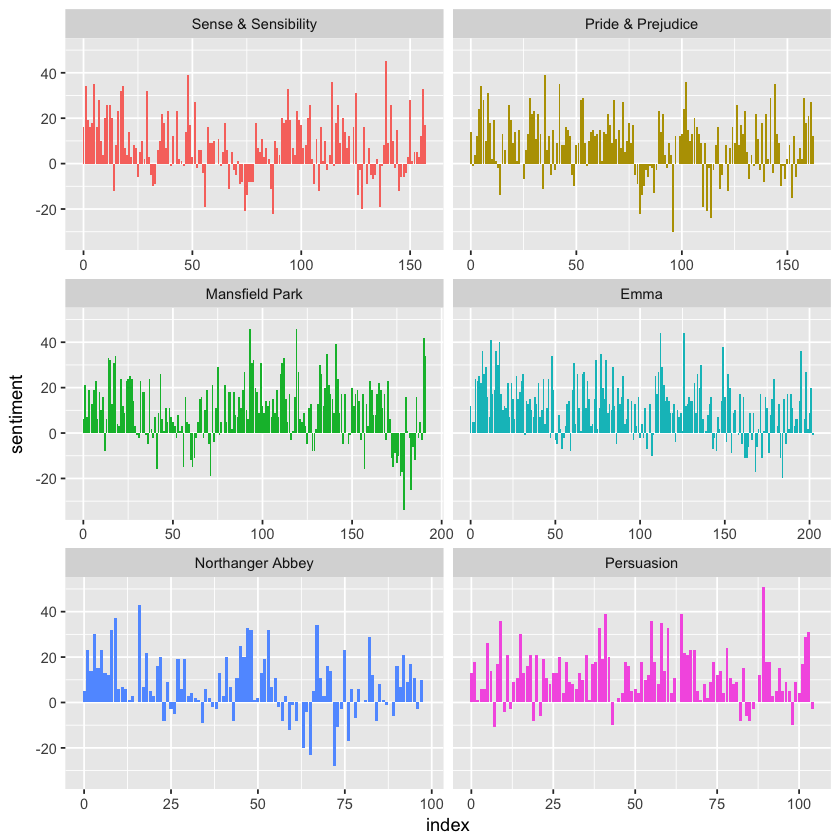

In [18]:
ggplot(janeaustensentiment, aes(index, sentiment, fill = book)) +
  geom_bar(stat = "identity", show.legend = FALSE) +
  facet_wrap(~book, ncol = 2, scales = "free_x")